## Imports

In [ ]:
import os
import torch
import numpy as np
import pandas as pd
import seaborn as sns 
import scipy
import matplotlib.pyplot as plt

from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torch.distributions import MultivariateNormal
from torchvision.models import inception_v3
from PIL import Image

torch.manual_seed(0) 

In [3]:
class Generator(nn.Module):
  
    def __init__(self, z_dim=10, im_chan=3, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
       
        self.gen = nn.Sequential(
            self.make_gen_block(z_dim, hidden_dim * 8),
            self.make_gen_block(hidden_dim * 8, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True),
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Tanh(),
            )

    def forward(self, noise):
        x = noise.view(len(noise), self.z_dim, 1, 1)
        return self.gen(x)


## Dataset

In [4]:
z_dim = 64
image_size = 299
n_samples = 512 
batch_size = 4
device = 'cuda'

In [5]:
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

class CelebADataset(Dataset):
    def __init__(self, image_folder, transform=None):
        self.image_folder = image_folder
        self.image_names = os.listdir(image_folder)
        self.transform = transform
        
    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, index):
        img_name = self.image_names[index]
        img_path = os.path.join(self.image_folder, img_name)    
        image = Image.open(img_path).convert("RGB")

        if self.transform is not None:
            image = self.transform(image)

        return image

In [6]:
image_folder = "./CelebA/img_align_celeba/img_align_celeba/"
dataset = CelebADataset(image_folder, transform=transform)
dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True)

## Loading Models

In [7]:
gen = Generator(z_dim).to(device)
gen.load_state_dict(torch.load(f"pretrained_celeba.pth", map_location=torch.device(device))["gen"])
gen = gen.eval()

In [ ]:
inception_model = inception_v3(pretrained=False)
inception_model.load_state_dict(torch.load("inception_v3_google-1a9a5a14.pth"))
inception_model.to(device)
inception_model = inception_model.eval() 
inception_model.fc = torch.nn.Identity()

## Fréchet Inception Distance

In [9]:
def get_noise(n_samples, z_dim, device='cpu'):

    return torch.randn(n_samples, z_dim, device=device)

In [10]:
def matrix_sqrt(x):
  
    y = x.cpu().detach().numpy()
    y = scipy.linalg.sqrtm(y)
    
    return torch.Tensor(y.real, device=x.device)

In [11]:
def frechet_distance(mu_x, mu_y, sigma_x, sigma_y):
    
    return (mu_x - mu_y).dot(mu_x - mu_y) + torch.trace(sigma_x) + torch.trace(sigma_y) - 2*torch.trace(matrix_sqrt(sigma_x @ sigma_y)) 

In [12]:
def preprocess(img):
    img = torch.nn.functional.interpolate(img, size=(299, 299), mode='bilinear', align_corners=False)
    
    return img

In [13]:
def get_covariance(features):
    return torch.Tensor(np.cov(features.detach().numpy(), rowvar=False))

In [14]:
fake_features_list = []
real_features_list = []

n_samples = 512
batch_size = 4 

cur_samples = 0

with torch.no_grad(): 

    try:

        for real_example in tqdm(dataloader, total=n_samples // batch_size): 
            real_samples = real_example
            real_features = inception_model(real_samples.to(device)).detach().to('cpu') 
            real_features_list.append(real_features)

            fake_samples = get_noise(len(real_example), z_dim).to(device)
            fake_samples = preprocess(gen(fake_samples))
            fake_features = inception_model(fake_samples.to(device)).detach().to('cpu') 
            fake_features_list.append(fake_features)
            
            cur_samples += len(real_samples)

            if cur_samples >= n_samples:
                break
    except:
        print("Error in loop")

 99%|█████████▉| 127/128 [00:13<00:00,  9.46it/s]


In [15]:
print(len(real_features_list))

128


In [16]:
fake_features_all = torch.cat(fake_features_list)
real_features_all = torch.cat(real_features_list)
print(real_features_all.shape)

torch.Size([512, 2048])


In [17]:
mu_fake = fake_features_all.mean(0)
mu_real = real_features_all.mean(0)
sigma_fake = get_covariance(fake_features_all)
sigma_real = get_covariance(real_features_all)

In [18]:
with torch.no_grad():
    print(frechet_distance(mu_real, mu_fake, sigma_real, sigma_fake).item())

141.83595275878906


## Visualization

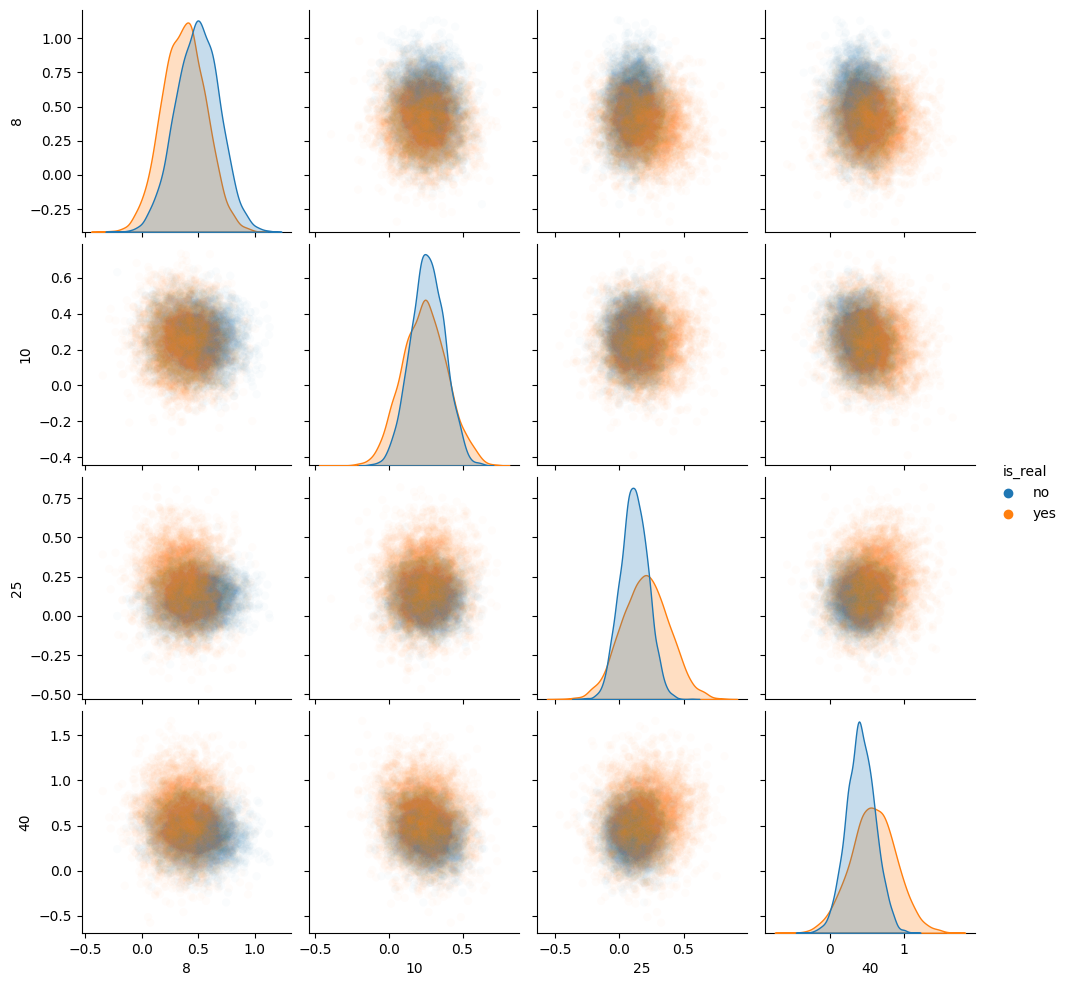

In [20]:
indices = [8, 10, 25, 40]
fake_dist = MultivariateNormal(mu_fake[indices], sigma_fake[indices][:, indices])
fake_samples = fake_dist.sample((5000,))
real_dist = MultivariateNormal(mu_real[indices], sigma_real[indices][:, indices])
real_samples = real_dist.sample((5000,))

df_fake = pd.DataFrame(fake_samples.numpy(), columns=indices)
df_real = pd.DataFrame(real_samples.numpy(), columns=indices)

df_fake["is_real"] = "no"
df_real["is_real"] = "yes"

df = pd.concat([df_fake, df_real])

sns.pairplot(df, plot_kws={'alpha': 0.02}, hue='is_real')